<a href="https://colab.research.google.com/github/KozhevnikovAlexandr/zootopia-project/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.python.keras.models import Sequential
from google.colab import drive
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt

In [ ]:
# Путь к фотографиям с телефонами для обучения
phone_path = '/content/generated_photo'
test_path = '/content/generated_test'
# Размеры изображения
img_width, img_height = 240, 240
# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (img_width, img_height, 3)
# Размер мини-выборки 
batch_size = 100
x_train = []
GENERATE_RES = 3
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/gan'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
#подключение гугл диска
!mkdir /content/drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def unzip(path):
  z = zipfile.ZipFile(path, 'r')
  z.extractall()

In [ ]:
#распаковка архивов
unzip('/content/drive/MyDrive/generated_photo.zip')
unzip('/content/drive/MyDrive/generated_test.zip')

In [ ]:
for root, dirs, files in os.walk(phone_path):
    for file in files:
      path = os.path.join(phone_path, file)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE), Image.ANTIALIAS)
      x_train.append(np.asarray(image))

In [ ]:
x_train = np.reshape(x_train,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
x_train = x_train.astype(np.float32)
x_train = x_train / 127.5 - 1.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(3,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

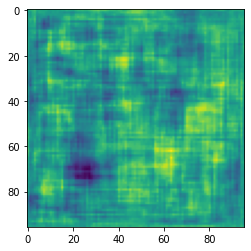

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
discriminator = build_discriminator(image_shape)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fa.ke_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}', epoch_elapsed)
    save_images(epoch,fixed_seed)

  elapsed = time.time() - start
  print(elapsed)

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1
  
  filename = os.path.join('/content/gan', f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [35]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.675187110900879,disc loss=0.42864513397216797 394.3063051700592
Epoch 2, gen loss=4.022143840789795,disc loss=0.11326111853122711 389.4714505672455
Epoch 3, gen loss=4.764835834503174,disc loss=0.06471160054206848 390.95303654670715
Epoch 4, gen loss=5.03190803527832,disc loss=0.05507270246744156 390.93405842781067
Epoch 5, gen loss=5.155091285705566,disc loss=0.055806439369916916 389.5909957885742
Epoch 6, gen loss=5.348048686981201,disc loss=0.048463769257068634 394.26572585105896
Epoch 7, gen loss=5.795138835906982,disc loss=0.05009874328970909 394.2952916622162
Epoch 8, gen loss=5.9419779777526855,disc loss=0.05222657695412636 398.0240685939789
Epoch 9, gen loss=5.716331481933594,disc loss=0.05938555300235748 393.486855506897
Epoch 10, gen loss=5.994823455810547,disc loss=0.056081533432006836 394.8489534854889
Epoch 11, gen loss=6.434152603149414,disc loss=0.07040587067604065 394.0962345600128
Epoch 12, gen loss=6.729219436645508,disc loss=0.16472302377223969 39

KeyboardInterrupt: ignored

In [ ]:
generator.save('/content/drive/MyDrive/gan_generator.h5')